In [1]:
import nibabel as nib
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import csv

base_dir = '/home/fhd/projects/.DATASETS/HealthyControls/'
ind_dir = os.path.join(base_dir,'C01')
rec_path = os.path.join(ind_dir,'left_foot_trial_21.nii')
INPUT = 'input.csv'

#defing necessary functoins
def read_single(img_path:str) -> np.memmap:
    '''function that gets the path of a single record and returns the memmap array in shape of (36,20,:)'''
    img = nib.load(img_path)
    try:
        data = img.get_fdata()
        if not (data.shape[1] <20 or data.shape[0] < 35):
            return img.get_fdata()[:35,:20,:]
    except :
        return None

def read_all(all_path:list) -> pd.DataFrame:
    '''get list of paths and returns of Y memmap of all records shape of (36,20,:)'''
    Y = np.zeros((35,20,0)) # initiating Y 
    #reading all images
    for path in all_path:
        arr = read_single(os.path.join(ind_dir,path))
        if type(arr)==np.memmap: Y = np.append(Y,arr,axis=2) #appending to Y
    return Y
    
def preprocess(memmap:np.memmap) -> pd.DataFrame:
    memmap = memmap.reshape(-1, memmap.shape[-1])
    return pd.DataFrame(memmap).T

def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(10,)))
    model.add(tf.keras.layers.Dense(16,activation='relu'))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(256,activation='relu'))
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dense(700,activation='linear'))
    model.compile(optimizer='adam', loss='mse',metrics=['MeanSquaredError','mae'])
    return model

def get_all_path( Left:bool =True, ex=None,inc=None) -> list:
    '''if you want the left foot then put True else Flase, parameter ex excludes from output'''
    all_path=[]
    for folder in list(os.walk(base_dir)):
        for filename in folder[2]:
            if Left:
                if 'left' in filename:
                    all_path.append(os.path.join(folder[0],filename))
            else:
                if 'right' in filename:
                    all_path.append(os.path.join(folder[0],filename))
    if ex: all_path= list(filter(lambda x: ex not in x,all_path))
    elif inc: all_path= list(filter(lambda x: inc in x,all_path))
    return all_path

def read_input(INPUT):
    x_input,y_input,p=[],[],[]
    with open(INPUT, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            x_input.append(row[0])
            y_input.append(row[1])
            p.append(row[2])
        f.close()
    x_input = np.array(x_input[1:],dtype=float)
    y_input = np.array(y_input[1:],dtype=float)
    p = np.array(p[1:],dtype=float)
    return x_input,y_input,p

def animate(x:np.array,y:np.array,result:pd.DataFrame,name:str,max=300):
    if not 'output' in os.listdir(): os.mkdir('output')
    if type(result)==pd.DataFrame:
        result = result.to_numpy()
    result=result[:max]
    fig, ax=plt.subplots(figsize=(3,6))
    p = [ax.tricontourf(x,y,result[0],cmap='Reds')]
    def update(i):
        for tp in p[0].collections:
            tp.remove()
        p[0] = ax.tricontourf(x,y,result[i],cmap='Reds') 
        return p[0].collections

    ani = animation.FuncAnimation(fig, update, blit=True, repeat=True)
    ani.save(os.path.join('output',name), fps=30)

def convert_2dIndex_to_1d(index):
    shape = (35,20)
    x,y = index
    _,Y = shape
    return x*Y+y
        

#making Y dataset
all_path = get_all_path(ex='C31')
Y = read_all(all_path)
Y = preprocess(Y)

##making X dataset
#selected_nodes_2d =[(14,4),(11,4),(5,21),(3,22),(10,27),(7,32),(6,30),(9,32),(12,27),(6,23)]
#selected_nodes_1d = list(map(convert_2dIndex_to_1d,selected_nodes_2d))
#X = Y[selected_nodes_1d]
#
## Splitting datasets
#X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, shuffle =False)

2022-04-07 00:51:55.659611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 00:51:55.659653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pysensors as ps  
class important_nodes:
    def __init__(self,df,n):
        
        self.get_imp(df,n)

    def get_imp(self,df,n):
        model = ps.SSPOR(
            basis=ps.basis.SVD(n_basis_modes=10),
            n_sensors=n
        )
        model.fit(df.to_numpy())
        self.sensors = model.get_selected_sensors()
        return self.sensors

In [3]:
Y = Y.loc[:,(Y!=0).any(axis=0)]

In [4]:
Y  =Y.T.reset_index().drop(columns=['index']).T

In [5]:
selected = important_nodes(Y,5).sensors
selected

array([346, 105,  63, 427, 453], dtype=int32)

In [7]:
Y = Y-Y.mean()/Y.std()

In [12]:
X = Y[selected]
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, shuffle =False)

In [13]:
import tensorflow.keras.backend as K

def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(4,)))
    model.add(tf.keras.layers.Dense(16,activation='relu'))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(256,activation='relu'))
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dense(623,activation='linear'))
    model.compile(optimizer='adam', loss=RMSE ,metrics=['MeanSquaredError','mae','RootMeanSquaredError'])
    return model
def RMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model1 = create_model()
history = model1.fit(
    x=X_train, y=y_train, batch_size=64, epochs=3,
    validation_split=0.2, validation_data=None, shuffle=True,
    workers=2, use_multiprocessing=True
)


2022-04-07 00:56:00.640905: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 816005400 exceeds 10% of free system memory.


Epoch 1/3
2559/2559 [==============================] - 13s 5ms/step - loss: 3.9295 - mean_squared_error: 15.5726 - mae: 1.7035 - root_mean_squared_error: 3.9462 - val_loss: 3.7450 - val_mean_squared_error: 15.2005 - val_mae: 1.7550 - val_root_mean_squared_error: 3.8988
Epoch 2/3
2559/2559 [==============================] - 12s 5ms/step - loss: 3.8008 - mean_squared_error: 14.5054 - mae: 1.6074 - root_mean_squared_error: 3.8086 - val_loss: 3.7254 - val_mean_squared_error: 14.9553 - val_mae: 1.7247 - val_root_mean_squared_error: 3.8672
Epoch 3/3
2559/2559 [==============================] - 12s 5ms/step - loss: 3.7759 - mean_squared_error: 14.3166 - mae: 1.5842 - root_mean_squared_error: 3.7837 - val_loss: 3.7101 - val_mean_squared_error: 14.8439 - val_mae: 1.6860 - val_root_mean_squared_error: 3.8528


In [14]:
re = model1.evaluate(X_test,y_test)

1599/1599 [==============================] - 3s 2ms/step - loss: 3.6074 - mean_squared_error: 14.6621 - mae: 1.6718 - root_mean_squared_error: 3.8291


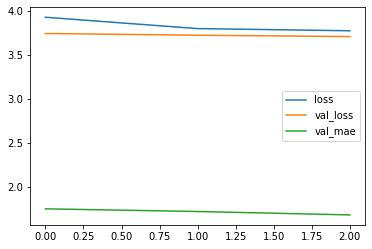

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.plot(history.history['mean_squared_error'], label='MeanSquaredError')
#plt.plot(history.history['mae'], label='mae')
#plt.plot(history.history['root_mean_squared_error'], label='RootMeanSquaredError')
#plt.plot(history.history['val_mean_squared_error'], label='val_MeanSquaredError')
plt.plot(history.history['val_mae'], label='val_mae')
#plt.plot(history.history['val_root_mean_squared_error'], label='val_RootMeanSquaredError')
plt.legend()

In [10]:
with open('result.txt','w') as f:
    f.write(str(['loss','mean_squared_error','mean_absolute_error','root_mean_squared_error'])+'\n')
    f.write(str(re))
    f.close()
model1.save('model.h5')